In [1]:
import pandas as pd
import numpy as np
from scipy.stats import norm
import copy
import matplotlib.pyplot as plt
from greeks_hedge_ratio import *
from strategy_builder import *

In [2]:
def butterfly(df, expiry, sd, atm_qty, wings_qty):

    for i in range(len(df)-1):

        base_val = df.loc[i, f"base_val_{expiry}"]
        dte = df.loc[i, f"DTE_{expiry}"]
        atm_vol = df.loc[i, f"atm_vol_{expiry}"]/100

        if df.loc[i, "expiry_date_1"] == df.loc[i+1, "expiry_date_1"] and df.loc[i+1, "base_change_1"] > -0.45:

            df.at[i,"positions"] = [{"strike":base_val*(1+sd*atm_vol*((dte/365)**0.5)), "expiry": expiry, "option_type": "call", "size": wings_qty * 10},
                                    {"strike":base_val*(1-sd*atm_vol*((dte/365)**0.5)), "expiry": expiry, "option_type": "put", "size": wings_qty * 10},
                                    {"strike":base_val, "expiry": expiry, "option_type": "call", "size": atm_qty * 10},
                                    {"strike":base_val, "expiry": expiry, "option_type": "put", "size": atm_qty * 10}]

        else:
            df.at[i,"positions"] = [{"strike":base_val, "expiry": expiry, "option_type": "call", "size": 0}]

    return df

def risk_reversal(df, expiry, sd, put_qty, call_qty):

    for i in range(len(df)-1):

        base_val = df.loc[i, f"base_val_{expiry}"]
        dte = df.loc[i, f"DTE_{expiry}"]
        atm_vol = df.loc[i, f"atm_vol_{expiry}"]/100

        if df.loc[i, "expiry_date_1"] == df.loc[i+1, "expiry_date_1"] and df.loc[i+1, "base_change_1"] > -0.45:

            df.at[i,"positions"] = [{"strike":base_val*(1+sd*atm_vol*((dte/365)**0.5)), "expiry": expiry, "option_type": "call", "size": call_qty * 10},
                                    {"strike":base_val*(1-sd*atm_vol*((dte/365)**0.5)), "expiry": expiry, "option_type": "put", "size": put_qty * 10}]

        else:
            df.at[i,"positions"] = [{"strike":base_val, "expiry": expiry, "option_type": "call", "size": 0}]

    return df


def strangle_swap(df, expiry_1, expiry_2, sd):

    for i in range(len(df)-1):

        base_val_1 = df.loc[i, f"base_val_{expiry_1}"]
        base_val_2 = df.loc[i, f"base_val_{expiry_2}"]
        dte_1 = df.loc[i, f"DTE_{expiry_1}"]
        dte_2 = df.loc[i, f"DTE_{expiry_2}"]
        atm_vol_1 = df.loc[i, f"atm_vol_{expiry_1}"]/100
        atm_vol_2 = df.loc[i, f"atm_vol_{expiry_2}"]/100

        if df.loc[i, "expiry_date_1"] == df.loc[i+1, "expiry_date_1"] and atm_vol_1 > atm_vol_2 and df.loc[i+1, "base_change_1"] > -0.45:

            df.at[i,"positions"] = [{"strike":base_val_1*(1+sd*atm_vol_1*((dte_1/365)**0.5)), "expiry": expiry_1, "option_type": "call", "size": -10},
                                    {"strike":base_val_1*(1-sd*atm_vol_1*((dte_1/365)**0.5)), "expiry": expiry_1, "option_type": "put", "size": -10},
                                    {"strike":base_val_2*(1+sd*atm_vol_2*((dte_2/365)**0.5)), "expiry": expiry_2, "option_type": "call", "size": 10},
                                    {"strike":base_val_2*(1-sd*atm_vol_2*((dte_2/365)**0.5)), "expiry": expiry_2, "option_type": "put", "size": 10}]

        elif df.loc[i, "expiry_date_1"] == df.loc[i+1, "expiry_date_1"] and atm_vol_1 < atm_vol_2 and df.loc[i+1, "base_change_1"] > -0.45:

            df.at[i,"positions"] = [{"strike":base_val_1*(1+sd*atm_vol_1*((dte_1/365)**0.5)), "expiry": expiry_1, "option_type": "call", "size": 10},
                                    {"strike":base_val_1*(1-sd*atm_vol_1*((dte_1/365)**0.5)), "expiry": expiry_1, "option_type": "put", "size": 10},
                                    {"strike":base_val_2*(1+sd*atm_vol_2*((dte_2/365)**0.5)), "expiry": expiry_2, "option_type": "call", "size": -10},
                                    {"strike":base_val_2*(1-sd*atm_vol_2*((dte_2/365)**0.5)), "expiry": expiry_2, "option_type": "put", "size": -10}]
        else:
            df.at[i,"positions"] = [{"strike":base_val_1, "expiry": expiry_1, "option_type": "call", "size": 0}]

    return df

def risk_reversal_swap(df, expiry_1, expiry_2, sd):

    for i in range(len(df)-1):

        base_val_1 = df.loc[i, f"base_val_{expiry_1}"]
        base_val_2 = df.loc[i, f"base_val_{expiry_2}"]
        dte_1 = df.loc[i, f"DTE_{expiry_1}"]
        dte_2 = df.loc[i, f"DTE_{expiry_2}"]
        atm_vol_1 = df.loc[i, f"atm_vol_{expiry_1}"]/100
        atm_vol_2 = df.loc[i, f"atm_vol_{expiry_2}"]/100

        if df.loc[i, "expiry_date_1"] == df.loc[i+1, "expiry_date_1"] and df.loc[i, f"skew_1_{expiry_1}"] > df.loc[i, f"skew_1_{expiry_2}"] and df.loc[i+1, "base_change_1"] > -0.45:

            df.at[i,"positions"] = [{"strike":base_val_1*(1+sd*atm_vol_1*((dte_1/365)**0.5)), "expiry": expiry_1, "option_type": "call", "size": -10},
                                    {"strike":base_val_1*(1-sd*atm_vol_1*((dte_1/365)**0.5)), "expiry": expiry_1, "option_type": "put", "size": 10},
                                    {"strike":base_val_2*(1+sd*atm_vol_2*((dte_2/365)**0.5)), "expiry": expiry_2, "option_type": "call", "size": 10},
                                    {"strike":base_val_2*(1-sd*atm_vol_2*((dte_2/365)**0.5)), "expiry": expiry_2, "option_type": "put", "size": -10}]

        elif df.loc[i, "expiry_date_1"] == df.loc[i+1, "expiry_date_1"] and df.loc[i, f"skew_1_{expiry_1}"] < df.loc[i, f"skew_1_{expiry_2}"] and df.loc[i+1, "base_change_1"] > -0.45:

            df.at[i,"positions"] = [{"strike":base_val_1*(1+sd*atm_vol_1*((dte_1/365)**0.5)), "expiry": expiry_1, "option_type": "call", "size": 10},
                                    {"strike":base_val_1*(1-sd*atm_vol_1*((dte_1/365)**0.5)), "expiry": expiry_1, "option_type": "put", "size": -10},
                                    {"strike":base_val_2*(1+sd*atm_vol_2*((dte_2/365)**0.5)), "expiry": expiry_2, "option_type": "call", "size": -10},
                                    {"strike":base_val_2*(1-sd*atm_vol_2*((dte_2/365)**0.5)), "expiry": expiry_2, "option_type": "put", "size": 10}]
        else:
            df.at[i,"positions"] = [{"strike":base_val_1, "expiry": expiry_1, "option_type": "call", "size": 0}]

    return df

def iv_rv_arb_ma(df, expiry, lookback, atm_qty):

    df["realised_vol"] = 1600 * abs(df[f"base_val_{expiry}"] - df[f"base_val_{expiry}"].shift(1))/df[f"base_val_{expiry}"].shift(1)
    df.loc[df["expiry_date_1"] != df["expiry_date_1"].shift(1), "realised_vol"] = 1600 * abs(df[f"base_val_{expiry}"] - df[f"base_val_{expiry + 1}"].shift(1))/df[f"base_val_{expiry + 1}"].shift(1)
    df["rvma"] = df["realised_vol"].rolling(window=lookback).mean()
    df["rvrms"] = np.sqrt((df["realised_vol"]**2).rolling(window=lookback).mean())

    for i in range(len(df)-1):

        base_val = df.loc[i, f"base_val_{expiry}"]

        if df.loc[i, "expiry_date_1"] == df.loc[i+1, "expiry_date_1"] and df.loc[i,  f"atm_vol_{expiry}"] > df.loc[i, "rvma"] and df.loc[i+1, "base_change_1"] > -0.45:

            df.at[i,"positions"] = [{"strike":base_val, "expiry": expiry, "option_type": "call", "size": -atm_qty * 10},
                                    {"strike":base_val, "expiry": expiry, "option_type": "put", "size": -atm_qty * 10}]
                                    
        else:
            df.at[i,"positions"] = [{"strike":base_val, "expiry": expiry, "option_type": "call", "size": 0}]

    return df

def iv_rv_arb_rms(df, expiry, lookback, atm_qty):

    df["realised_vol"] = 1600 * abs(df[f"base_val_{expiry}"] - df[f"base_val_{expiry}"].shift(1))/df[f"base_val_{expiry}"].shift(1)
    df.loc[df["expiry_date_1"] != df["expiry_date_1"].shift(1), "realised_vol"] = 1600 * abs(df[f"base_val_{expiry}"] - df[f"base_val_{expiry + 1}"].shift(1))/df[f"base_val_{expiry + 1}"].shift(1)
    df["rvma"] = df["realised_vol"].rolling(window=lookback).mean()
    df["rvrms"] = np.sqrt((df["realised_vol"]**2).rolling(window=lookback).mean())

    for i in range(len(df)-1):

        base_val = df.loc[i, f"base_val_{expiry}"]

        if df.loc[i, "expiry_date_1"] == df.loc[i+1, "expiry_date_1"] and df.loc[i,  f"atm_vol_{expiry}"] > df.loc[i, "rvrms"] and df.loc[i+1, "base_change_1"] > -0.45:

            df.at[i,"positions"] = [{"strike":base_val, "expiry": expiry, "option_type": "call", "size": -atm_qty * 10},
                                    {"strike":base_val, "expiry": expiry, "option_type": "put", "size": -atm_qty * 10}]
                                    
        else:
            df.at[i,"positions"] = [{"strike":base_val, "expiry": expiry, "option_type": "call", "size": 0}]

    return df

In [3]:
# df = generate_polynomial("BRN")
# df_test = iv_rv_arb(df.copy(), 1, 30, 1)
# df_test.to_excel("rv test.xlsx")

c:\Users\ryant\OneDrive\Desktop\Options Pricing Analysis\Backtest Engine\strategy_builder.py:128: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '-2.0800232929894236' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.loc[i, "PnL"] = pnl
c:\Users\ryant\OneDrive\Desktop\Options Pricing Analysis\Backtest Engine\strategy_builder.py:128: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.2254941327819182' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.loc[i, "PnL"] = pnl
c:\Users\ryant\OneDrive\Desktop\Options Pricing Analysis\Backtest Engine\strategy_builder.py:128: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '21.858717266899248' has dtype incompatible with int64,

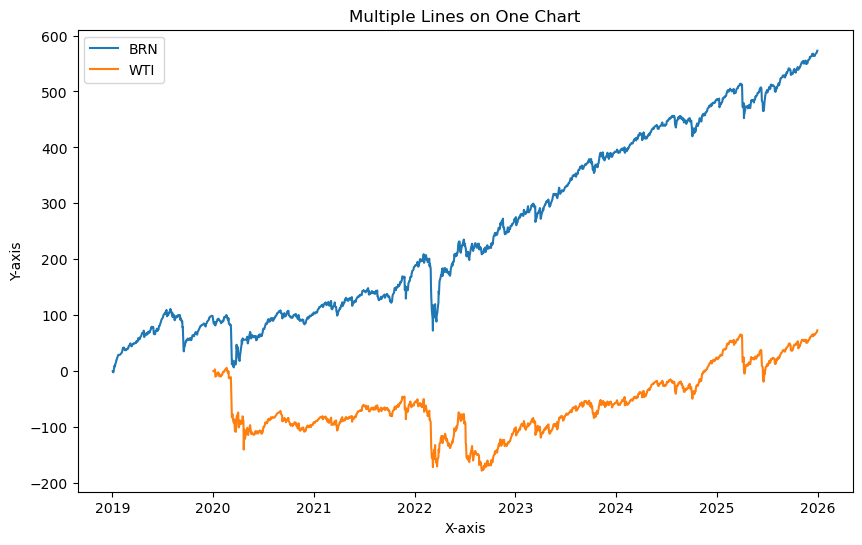

In [4]:
df_1 = generate_polynomial("BRN")
df_2 = generate_polynomial("LO")
df_3 = generate_polynomial("SPX")

df_strategy_1 = butterfly(df_1.copy(), 1, 0, -1, 0)
df_pnl_1 = calculate_pnl(df_strategy_1)

df_strategy_2 = butterfly(df_2.copy(), 1, 0, -1, 0)
df_pnl_2 = calculate_pnl(df_strategy_2)

df_strategy_3 = butterfly(df_3.copy(), 1, 0, -1, 0)
df_pnl_3 = calculate_pnl(df_strategy_3)

# Plot multiple lines
plt.figure(figsize=(10, 6))
plt.plot(df_pnl_1["date"], df_pnl_1["Cumulative PnL"], label='BRN')
plt.plot(df_pnl_2["date"], df_pnl_2["Cumulative PnL"], label='WTI')
# plt.plot(df_pnl_3["date"], df_pnl_3["Cumulative PnL"], label='SPX')

# Add labels, title, and legend
plt.xlabel("X-axis")
plt.ylabel("Y-axis")
plt.title("Multiple Lines on One Chart")
plt.legend()

# Show the plot
plt.show()

df = atm_straddle(df,1)
df = calculate_pnl(df)

c:\Users\ryant\OneDrive\Desktop\Options Pricing Analysis\Backtest Engine\strategy_builder.py:128: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '-0.36666678591910085' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.loc[i, "PnL"] = pnl
c:\Users\ryant\OneDrive\Desktop\Options Pricing Analysis\Backtest Engine\strategy_builder.py:128: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '-0.16314029362246352' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.loc[i, "PnL"] = pnl
c:\Users\ryant\OneDrive\Desktop\Options Pricing Analysis\Backtest Engine\strategy_builder.py:128: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '3.1005842233174974' has dtype incompatible with int

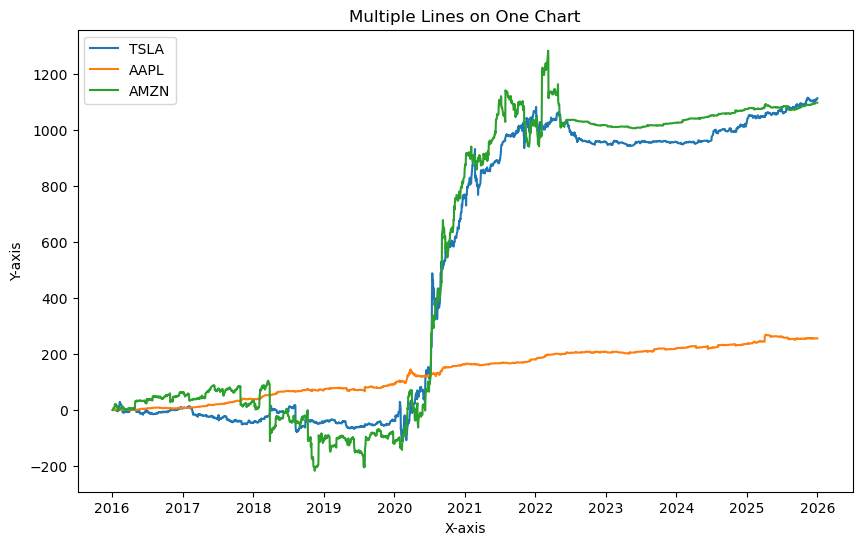

In [5]:
df_4 = generate_polynomial("TSLA")
df_5 = generate_polynomial("AAPL")
df_6 = generate_polynomial("AMZN")

df_strategy_4 = risk_reversal_swap(df_4.copy(), 1, 2, 1)
df_pnl_4 = calculate_pnl(df_strategy_4)

df_strategy_5 = risk_reversal_swap(df_5.copy(), 1, 2, 1)
df_pnl_5 = calculate_pnl(df_strategy_5)

df_strategy_6 = risk_reversal_swap(df_6.copy(), 1, 2, 1)
df_pnl_6 = calculate_pnl(df_strategy_6)

# Plot multiple lines
plt.figure(figsize=(10, 6))
plt.plot(df_pnl_4["date"], df_pnl_4["Cumulative PnL"], label='TSLA')
plt.plot(df_pnl_5["date"], df_pnl_5["Cumulative PnL"], label='AAPL')
plt.plot(df_pnl_6["date"], df_pnl_6["Cumulative PnL"], label='AMZN')

# Add labels, title, and legend
plt.xlabel("X-axis")
plt.ylabel("Y-axis")
plt.title("Multiple Lines on One Chart")
plt.legend()

# Show the plot
plt.show()